<a href="https://colab.research.google.com/github/gomzi-star/siz/blob/main/IZ_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DEFINITIONS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

##rhs
Right hand sides for the Izhikievich model in [Simple Model of Spiking Neurons](https://www.izhikevich.org/publications/spikes.pdf) eqs. (1) and (2). Variaton for certain neuron types acording to [MATLAB CODE](https://www.izhikevich.org/publications/figure1.m).

In [ ]:
def dvdt(v, u, I, tipo=None):
    """
    rhs for potential v.

    Parameters:
    v (float): Membrane Potential
    u (float): Recovery
    I (float): External input or current.
    tipo (int): Determines which specific fenonmenom to repriduce.

    Returns:
    float: dv/dt.
    """
    # Check if 'tipo' is 6 or 11 to use a specific formula
    if tipo == 6 or tipo == 11:
        # Formula specific to 'tipo' being 6 or 11
        return 0.04 * v**2 + 4.1 * v + 108 - u + I
    else:
        # General formula used for all other cases
        return 0.04 * v**2 + 5 * v + 140 - u + I


def dudt(v, u, a, b, tipo = None):
    """
    rhs for recovery u.

    Parameters:
    v (float): Membrane Potential
    u (float): Recovery
    a (float): Rate of recovery decay
    b (float): Sensitivity od recovery
    tipo (int): Determines which specific fenonmenom to repriduce.

    Returns:
    float: du/dt.
    """
    # Check if 'tipo' is 17 to use a specific formula
    if tipo == 17:
      return a * (b * (v + 65))
    else:
      # General formula used for all other cases
      return a * (b * v - u)

##imput curretn
Defining the way to inject current in a simulation (constant steps or ramps)

In [ ]:
def input_current(t, injections):
    """
    Determine the input current at time t based on a list of injections, including an option
    for linear crescent currents.

    Parameters:
    t (float): The current time in the simulation.
    injections (list): A list of tuples where each tuple can be one of the following:
                       - (end_time, current_value): for constant current.
                       - (end_time, initial_value, slope): for linearly increasing current.
                       The first injection starts at t=0.
    Returns:
    float: The current value at time t.
    """
    base = 0
    for injection in injections:
        if len(injection) == 2:
            end_time, current_value = injection
            if t < end_time:
                return current_value
        elif len(injection) == 3:
            end_time, initial_value, slope = injection
            if t < end_time:
                return  slope * (t - base)
        base = end_time

    return 0  # Return 0 if time exceeds the last defined end_time

##izz

In [ ]:
def iz(pars, tipo = 0, step = None, v_reset = 30):
    """
    Simulate a neuron's behavior using the Izhikevich model.

    Parameters:
    pars (list): Contains neuron parameters including:
                 title (str): Neuron type name,
                 a (float): Rate of recovery decay,
                 b (float): Sensitivity od recovery,
                 c (float): After spike reset for v,
                 d (float): After spike reset(add up) for u,
                 v_init (float): Initial value for v,
                 stepp (float): Step size for integration,
                 injections (list): A list of tuples where each tuple can be one of the following:
                                    - (end_time, current_value): for constant current.
                                    - (end_time, initial_value, slope): for linearly increasing current..
    tipo (int): Index for the type of neuron to simulate. Default is 0.
    step (float): Override for the time step size. Default is None (uses stepp from 'pars').
    v_reset (float): Voltage reset threshold for detecting spikes. Default is 30.

    Returns:
    tuple: tspan (time points), VV (voltage over time), uu (recovery variable over time), II (input currents).
    """
    # Unpack parameters for the given neuron type
    title, a, b, c, d, v_init, stepp, injections = pars[tipo]

    # Determine the time step (tau) to use
    if step is not None:
        tau = step  # Use the provided step size
    else:
        tau = stepp  # Default step size from 'pars'

    # Initialize variables
    V = v_init  # Initial membrane potential
    if tipo == 17:
        u = -16  # Special initialization for 'tipo' 17
    else:
        u = b * V  # Standard initialization for recovery variable

    # Generate time points based on the last injection time
    tspan = np.arange(0, injections[-1][0], tau)

    # Preallocate arrays for efficiency
    VV = np.zeros(len(tspan))  # Voltage trace
    uu = np.zeros(len(tspan))  # Recovery variable trace
    II = np.zeros(len(tspan))  # Input current trace

    # Simulation loop
    for i, t in enumerate(tspan):
        # Determine the input current at the current time step
        I = input_current(t, injections)
        II[i] = I  # Store the input current

        # Update membrane potential (V) and recovery variable (u) using numerical integration
        V = V + tau * dvdt(V, u, I, tipo)  # Update V using the derivative function `dvdt`
        u = u + tau * dudt(V, u, a, b, tipo)  # Update u using the derivative function `dudt`

        # Handle spike detection and resetting
        if V > 30:
            VV[i] = 30  # Record a spike (limit voltage to v_reset)
            V = c  # Reset membrane potential
            u = u + d  # Adjust recovery variable
        else:
            VV[i] = V  # Record the current membrane potential

        uu[i] = u  # Store the current recovery variable

    # Return simulation results: time points, voltage trace, recovery trace, and input currents
    return tspan, VV, uu, II

##plot

In [ ]:
def singleplot(tspan, VV, uu, II, title, c, v_init, ubot = None, utop = None):
    """
    Create a single figure with three subplots to visualize the simulation results:
    membrane potential (V), current injections (I), and recovery variable (u).

    Parameters:
    tspan (array-like): Time points for the simulation.
    VV (array-like): Membrane potential (V) values over time.
    uu (array-like): Recovery variable (u) values over time.
    II (array-like): Input current (I) values over time.
    title (str): Title for the plot.
    c (float): Threshold value for the membrane potential.
    v_init (float): Initial value of the membrane potential (used to set plot limits).
    ubot (float): Lower limit for the recovery variable plot (u-axis). Default is None.
    utop (float): Upper limit for the recovery variable plot (u-axis). Default is None.

    Returns:
    None: Displays the plots.
    """
    # Create a figure with three vertically stacked subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                                        gridspec_kw={'height_ratios': [3, 0.5, 2]},
                                        figsize=(8, 6))

    # Upper plot: Membrane potential V(t)
    ax1.plot(tspan, VV, label='v')  # Plot membrane potential over time
    ax1.plot(tspan, c * np.ones(len(tspan)), label='Threshold', linestyle='--', color='gray')  # Threshold line
    ax1.set_ylim(bottom=v_init - 15, top=30)  # Set y-axis limits based on v_init and threshold
    ax1.set_ylabel('Membrane Potential (mV)')  # Label for y-axis
    ax1.set_title(title)  # Plot title
    ax1.legend(loc='upper right')  # Add legend to the upper-right corner
    ax1.grid(True)  # Add grid lines for better readability

    # Middle plot: Current injections I(t)
    ax2.plot(tspan, II, color='black')  # Plot input current over time
    ax2.set_ylabel('Current')  # Label for y-axis
    # Remove unnecessary spines for a cleaner look
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.xaxis.set_ticks([])  # Remove x-axis ticks for this plot

    # Lower plot: Recovery variable u(t)
    ax3.plot(tspan, uu, label='u', color='C1')  # Plot recovery variable over time
    ax3.set_ylabel('Recovery')  # Label for y-axis
    ax3.set_xlabel('Time (ms)')  # Label for x-axis
    ax3.legend(loc='upper right')  # Add legend to the upper-right corner
    ax3.set_ylim(bottom=ubot, top=utop)  # Set y-axis limits for the recovery variable
    ax3.grid(True)  # Add grid lines for better readability

    # Adjust layout to prevent overlap between subplots
    plt.tight_layout()
    # Display the figure
    plt.show()


##pars
List of different parameters for each neuron type, taken from [MATLAB CODE](https://www.izhikevich.org/publications/figure1.m). tau(stepsize)=0.1 for all types in contrast to origial code. I_form(imput current) could be slighlty different from the original code also. For a detailed explanation of each type go to Izhikievich's article [Which Model to Use for Cortical Spiking Neurons?
](https://www.izhikevich.org/publications/whichmod.pdf)

In [ ]:
pars=[
#-names------------------------------------a-------b------c-------d---v_init-----tau----I_form
['0 - tonic spiking',                   0.02,    0.2,   -65,      6,     -70,    0.1,   [[10,0],[100,14]]],
['1 - phasic spiking',                  0.02,   0.25,   -65,      6,     -64,    0.1,   [[20,0],[200,0.5]]],
['2 - tonic bursting',                  0.02,    0.2,   -50,      2,     -70,    0.1,   [[22,0],[220,15]]],
['3 - phasic bursting',                 0.02,   0.25,   -55,   0.05,     -64,    0.1,   [[20,0],[200,0.6]]],
['4 - mixed mode',                      0.02,    0.2,   -55,      4,     -70,    0.1,   [[16,0],[160,10]]],
['5 - spike frequency adaptation',      0.01,    0.2,   -65,      8,     -70,    0.1,   [[85/10,0],[85,30]]],
['6 - class 1',                         0.02,   -0.1,   -55,      6,     -60,    0.1,   [[30,0,0],[300,0,0.075]]], # (I RARO y NO USA EL DEL PAPER)],
['7 - class 2',                          0.2,   0.26,   -65,      0,     -64,    0.1,   [[30,-0.5,0],[300,-0.5,0.015]]], # (I RARO y NO USA EL DEL PAPER)],
['8 - spike latency',                   0.02,    0.2,   -65,      6,     -70,    0.1,   [[10,0],[13,7.04],[100,0]]],
['9 - subthreshold oscillations',       0.05,   0.26,   -60,      0,     -62,    0.1,   [[20,0],[25,2],[200,0]]],
['10 - resonator',                       0.1,   0.26,   -60,     -1,     -62,    0.1,   [[40,0],[44,0.65],[60,0],[64,0.65],[280,0],[284,0.65],[320,0],[324,0.65],[400,0]]],
#-names------------------------------------a-------b------c-------d---v_init-----tau----I_form
['11 - integrator',                     0.02,   -0.1,   -55,      6,     -60,    0.1,   [[100/11,0],[100/11+2,9], [100/11+5,0],[100/11+7,9], [70,0],[72,9], [80,0],[82,9],[100,0]]],
['12 - rebound spike',                  0.03,   0.25,   -60,      4,     -64,    0.1,   [[20,0],[25,-15],[200,0]]],
['13 - rebound burst',                  0.03,   0.25,   -52,      0,     -64,    0.1,   [[20,0],[25,-15],[200,0]]],
['14 - threshold variability',          0.03,   0.25,   -60,      4,     -64,    0.1,   [[10,0],[15,1],[70,0],[75,-6],[80,0],[85,1],[100,0]]],
['15 - bistability',                     0.1,   0.26,   -60,      0,     -61,    0.1,   [[37.5,0.24],[42.5,1.24],[209,0.24],[214,1.24],[300,0.24]]],
['16 - DAP',                               1,    0.2,   -60,    -21,     -70,    0.1,   [[9,0],[11,20],[50,0]]],
['17 - accomodation',                   0.02,      1,   -55,      4,     -65,    0.1,   [[200,0,1/25],[300,0,0],[312.5,0,1/12.5*4],[400,0,0]]], #IRARO
['18 - inhibition-induced spiking',    -0.02,     -1,   -60,      8,   -63.8,    0.1,   [[50,80],[225,75],[350,80]]],
['19 - inhibition-induced bursting',  -0.026,     -1,   -45,     -2,   -63.8,    0.5,   [[50,80],[250,75],[350,80]]],
['20 - chaos',                           0.2,      2,   -56,    -16,     -60,    0.01,  [[200,-99]]],
#-names------------------------------------a-------b------c-------d---v_init-----tau----I_form
       ]

#RUN

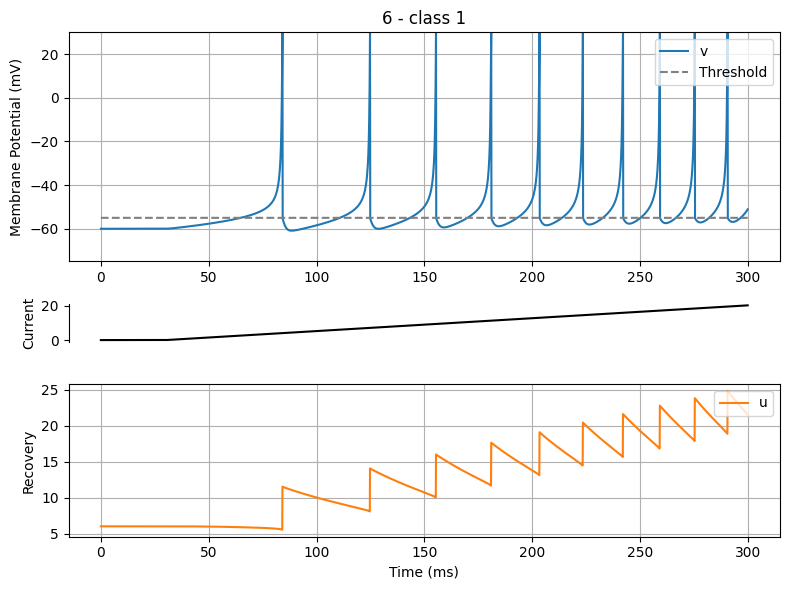

In [ ]:
tipo = "16" # @param [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
tipo = int(tipo)
step = None # @param {type:"number", placeholder:"enter a value for custom step"}
ubot = None # @param {type:"number", placeholder:"enter a value if wanted u inferior limit"}
utop = None # @param {type:"number", placeholder:"enter a value if wanted u superior limit"}
tspan, VV, uu, II = iz(pars,tipo,step);
singleplot(tspan,VV,uu,II,pars[tipo][0],pars[tipo][3],pars[tipo][5],ubot,utop)

#SHEET

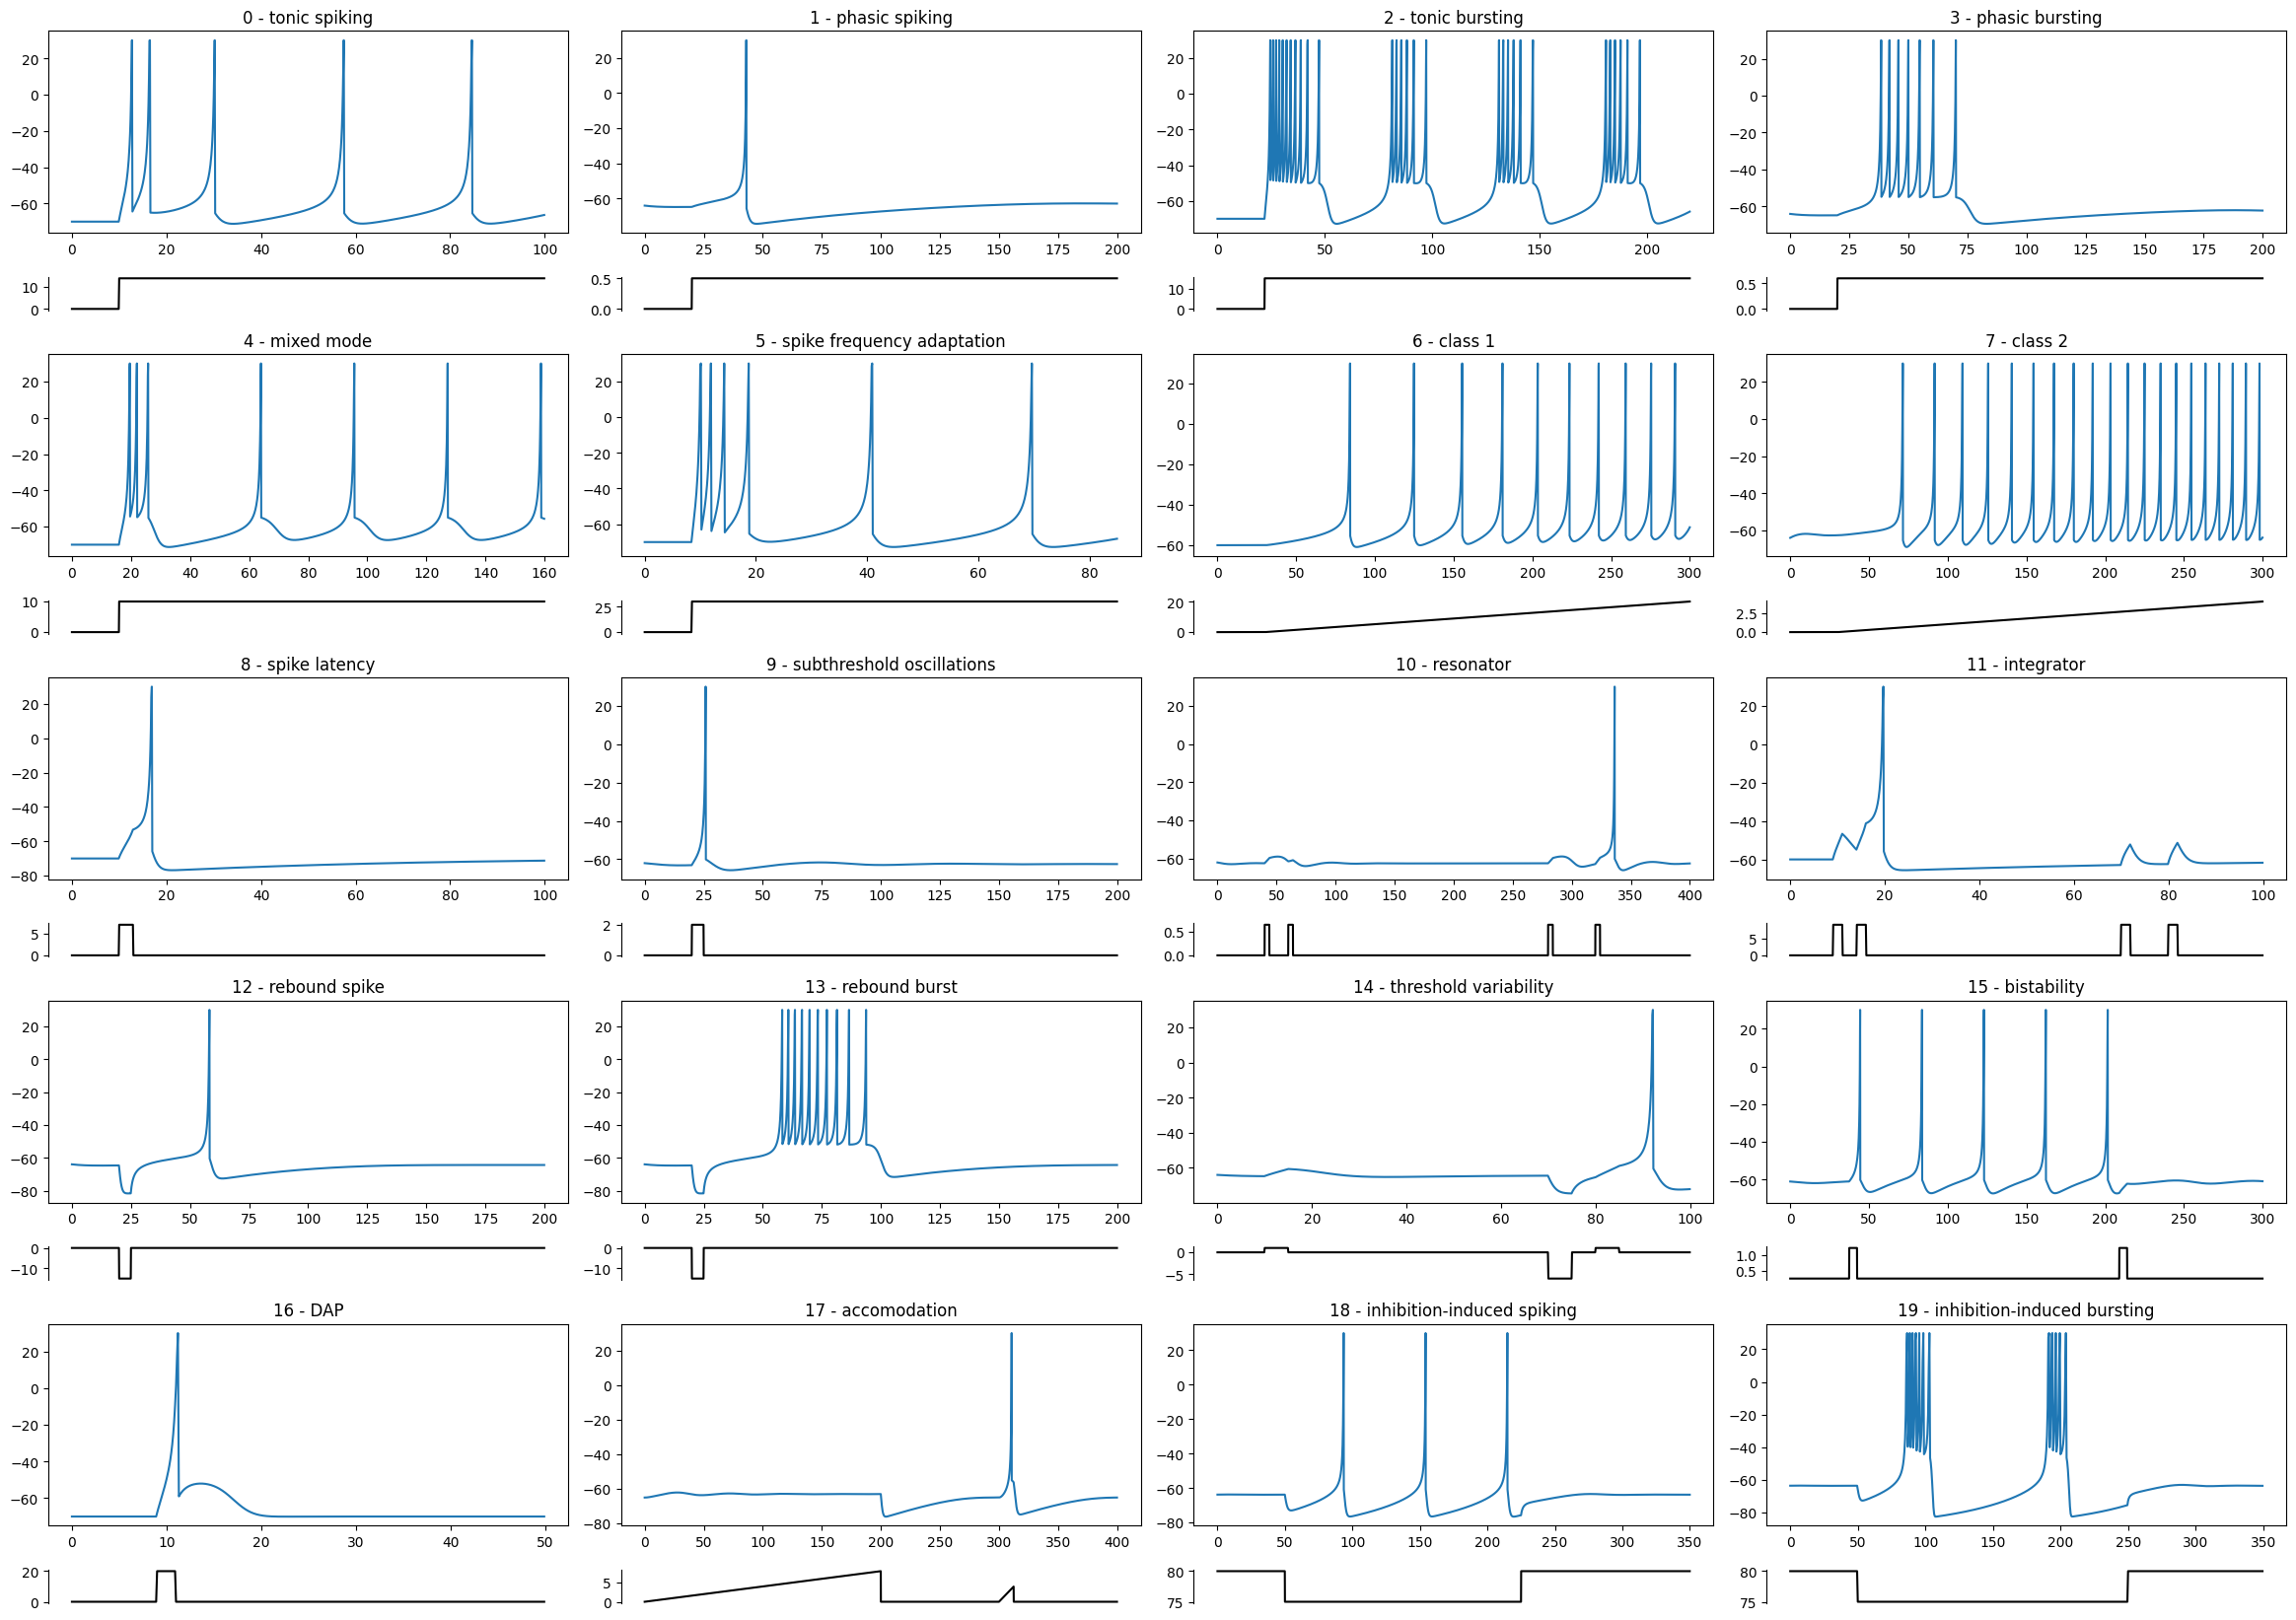

In [ ]:
# Set up a grid of subplots for visualizing neuron dynamics
fig, ax = plt.subplots(
    ncols=4,        # 4 columns of subplots
    nrows=10,       # 10 rows of subplots
    gridspec_kw={'height_ratios': [3, 0.5, 3, 0.5, 3, 0.5, 3, 0.5, 3, 0.5]},  # Adjust height ratios for alternating large and small plots
    figsize=(11.69 * 2, 8.27 * 2),  # Overall figure size
    dpi=100                         # Dots per inch for figure resolution
)

k = 0           # Index for accessing neuron types from the 'pars' list
vbox = []       # To store the vertical axis limits for membrane potential plots

# Loop through the rows and columns of the grid
for i in range(0, 10, 2):  # Iterate through every second row (for membrane potential plots)
    for j in range(4):     # Iterate through columns
        # Simulate the dynamics for the k-th neuron type
        tspan, VV, uu, II = iz(pars, tipo=k)

        # Upper plot: Membrane potential V(t)
        ax[i, j].plot(tspan, VV, color='C0')  # Plot membrane potential over time
        ax[i, j].set_title(pars[k][0])        # Set the title to the name of the neuron type
        vbox.append(ax[i, j].get_ylim())      # Store the y-axis limits for later adjustments

        # Lower plot: Input current I(t)
        ax[i + 1, j].plot(tspan, II, color='black')       # Plot input current over time
        ax[i + 1, j].spines['top'].set_visible(False)     # Remove the top spine for aesthetics
        ax[i + 1, j].spines['right'].set_visible(False)   # Remove the right spine
        ax[i + 1, j].spines['bottom'].set_visible(False)  # Remove the bottom spine
        ax[i + 1, j].xaxis.set_ticks([])                  # Remove x-axis ticks for a clean look

        # Increment the neuron type index
        k = k + 1

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
